In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 22 20:18:19 2021

@author: xuquanfeng
"""
from PIL import Image
import torch
from torchvision import datasets,transforms,utils,models
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import random
import os
import datetime
import torchvision
import torch.nn.functional as F
from astropy.io import fits
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch import optim
#设置随机种子

# Hyper parameters
num_epochs = 100   #循环次数
batch_size = 128    #每次投喂数据量
learning_rate = 0.00001
#学习率
momentum = 0.9
correct = 0
total = 0
correct1 = 0
total1 = 0
num_correct = 0
num_correct2 =0

class MyDataset(torch.utils.data.Dataset):  # 创建自己的类：MyDataset,这个类是继承的torch.utils.data.Dataset
    def __init__(self, datatxt, transform=None, target_transform=None):  # 初始化一些需要传入的参数
        super(MyDataset, self).__init__()
        fh = open(datatxt, 'r')  # 按照传入的路径和txt文本参数，打开这个文本，并读取内容
        imgs = []  # 创建一个名为img的空列表，一会儿用来装东西
        for line in fh:  # 按行循环txt文本中的内容
            line = line.rstrip()  # 删除 本行string 字符串末尾的指定字符，这个方法的详细介绍自己查询python
            # words = line.split()  # 通过指定分隔符对字符串进行切片，默认为所有的空字符，包括空格、换行、制表符等
            imgs.append((line))
            # 很显然，words[0]是图片信息，words[1]是lable
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):  # 这个方法是必须要有的，用于按照索引读取每个元素的具体内容
        fn = self.imgs[index]  # fn是图片path #fn和label分别获得imgs[index]也即是刚才每行中word[0]和word[1]的信息
        hdu = fits.open(fn)
        img = hdu[0].data
        img = np.array(img,dtype=np.float32)
        # img.resize(128,128)
        hdu.close()
        label = 0
        # img = addnoise(img)
        # img = Image.open(fn).convert('L')  # 按照path读入图片from PIL import Image # 按照路径读取图片 彩色图片则为RGB
        # img = img.resize((128,128))
        if self.transform is not None:
            # n = len(img)
            # if n>=255:
            img = self.transform(img)
        #     else:
        #         tran2 = transforms.Compose([
        #             transforms.ToTensor(),
        #             transforms.Pad(int((255-n)/2),padding_mode='edge'),
        #             transforms.Resize(255),
        #             ])
        #         img = tran2(img)
        return img, label  # return很关键，return回哪些内容，那么我们在训练时循环读取每个batch时，就能获得哪些内容

    def __len__(self):  # 这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.imgs)
trans = transforms.Compose([
    transforms.ToTensor(),
    # transforms.CenterCrop(255),
    # transforms.Resize(255),
    ])
root = '/data/GZ_Decals/'
# 根据自己定义的那个类MyDataset来创建数据集！注意是数据集！而不是loader迭代器
train_data = MyDataset(datatxt=root + 'train1.txt', transform=transforms.ToTensor())

#然后就是调用DataLoader和刚刚创建的数据集，来创建dataloader，这里提一句，loader的长度是有多少个batch，所以和batch_size有关
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True,num_workers=20)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        modules = []
        hidden_dims = [32, 64, 128, 256, 512]
        in_channels = 3
        latent_dim = 100
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*64, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*64, latent_dim)
        
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 64)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

        # self.fc1 = nn.Linear(3*256*256, 2048)
        # self.fc12 = nn.Linear(2048,400)
        # self.fc21 = nn.Linear(400, 12)
        # self.fc22 = nn.Linear(400, 12)
        # self.fc3 = nn.Linear(12, 400)
        # self.fc31 = nn.Linear(400,2048)
        # self.fc4 = nn.Linear(2048, 3*256*256)

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var
        # h2 = F.relu(self.fc1(x))
        # h1 = F.relu(self.fc12(h2))
        # return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        result = self.decoder_input(z)
        result = result.view(len(result), 512, 8, 8)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
        # h4 = F.relu(self.fc3(z))
        # h3 = F.relu(self.fc31(h4))
        # # return F.sigmoid(self.fc4(h3))
        # # return torch.sigmoid(self.fc4(h3))
        # return F.relu(self.fc4(h3))

    def forward(self, x):
        # x = x.view(len(x),-1)
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
torch.cuda.empty_cache()
model = torch.load('./models/vae99_100.pth')

print(model)

# Device configuration  判断能否使用cuda加速
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = model.to(device)

reconstruction_function = nn.MSELoss(size_average=False)



optimizer = optim.Adam(model.parameters(), lr=learning_rate)
strattime = datetime.datetime.now()
for epoch in range(1):
    model.eval()
    # datt = []
    datt = np.array(range(40))
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        img, _ = data
        # img = img.view(img.size(0), -1)
        img = img.permute(0,2,1,3)
        img = img.view(img.size(0), 3,256,256)
        img = Variable(img)
        img = (img.cuda() if torch.cuda.is_available() else img)
        # optimizer.zero_grad()
        imgs, mu, logvar = model(img)
        break
    break



PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


/data/xqf/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


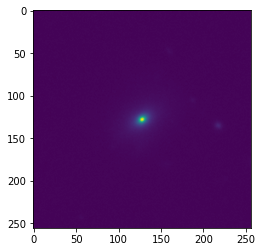

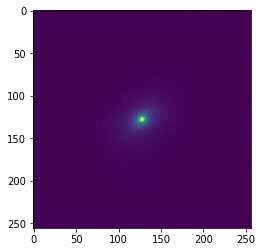

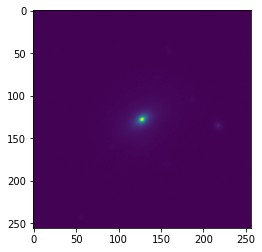

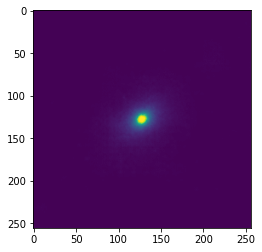

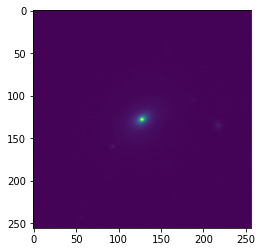

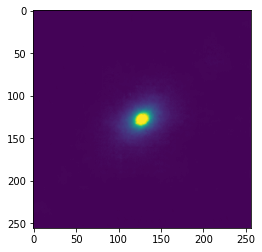

In [25]:
yunatu = img.cpu().numpy()
houtu = imgs.cpu().detach().numpy()
a=0

for i in range(3):
    
#     plt.subplot(3,2,1+2*i)
    plt.imshow(yunatu[a][i])    
    plt.show()
    # plt.imshow(yunatu[a][:,i,:])
#     plt.subplot(3,2,2+2*i)
    plt.imshow(houtu[a][i])
    plt.show()

# plt.figure(1)
# for i in range(3):
    
#     plt.subplot(3,2,1+2*i)
#     plt.imshow(yunatu[a][i])
#     # plt.imshow(yunatu[a][:,i,:])
#     plt.subplot(3,2,2+2*i)
#     plt.imshow(houtu[a][i])
# plt.show()

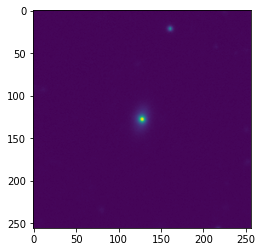

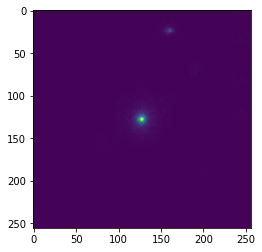

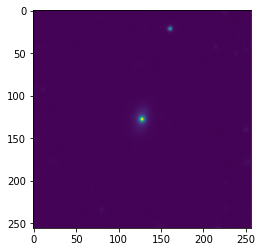

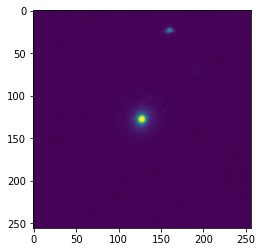

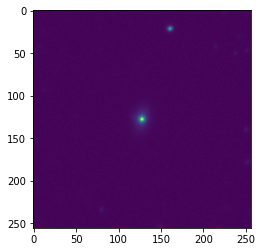

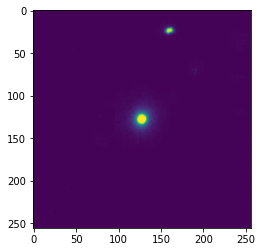

In [26]:
yunatu = img.cpu().numpy()
houtu = imgs.cpu().detach().numpy()
a=17

for i in range(3):
    
#     plt.subplot(3,2,1+2*i)
    plt.imshow(yunatu[a][i])    
    plt.show()
    # plt.imshow(yunatu[a][:,i,:])
#     plt.subplot(3,2,2+2*i)
    plt.imshow(houtu[a][i])
    plt.show()

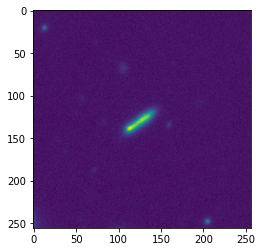

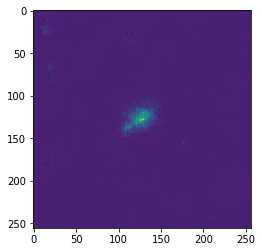

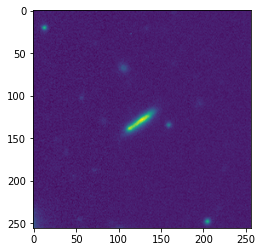

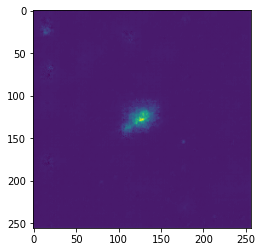

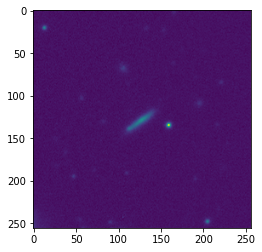

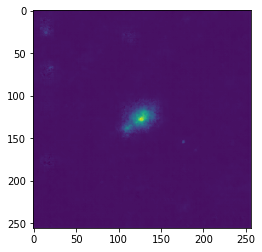

In [27]:
yunatu = img.cpu().numpy()
houtu = imgs.cpu().detach().numpy()
a=18

for i in range(3):
    
#     plt.subplot(3,2,1+2*i)
    plt.imshow(yunatu[a][i])    
    plt.show()
    # plt.imshow(yunatu[a][:,i,:])
#     plt.subplot(3,2,2+2*i)
    plt.imshow(houtu[a][i])
    plt.show()

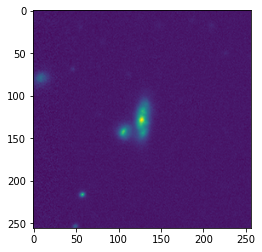

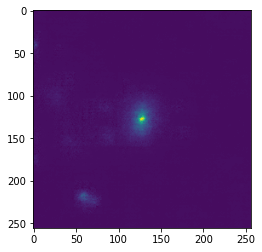

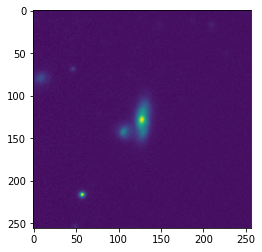

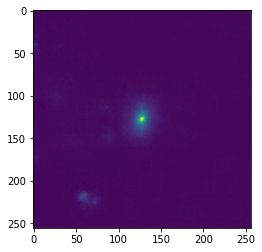

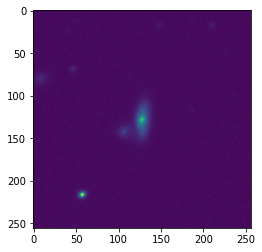

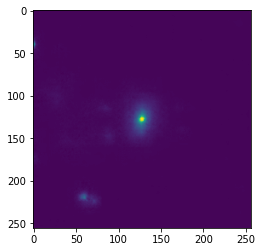

In [29]:
yunatu = img.cpu().numpy()
houtu = imgs.cpu().detach().numpy()
a=11

for i in range(3):
    
#     plt.subplot(3,2,1+2*i)
    plt.imshow(yunatu[a][i])    
    plt.show()
    # plt.imshow(yunatu[a][:,i,:])
#     plt.subplot(3,2,2+2*i)
    plt.imshow(houtu[a][i])
    plt.show()

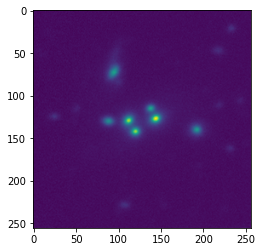

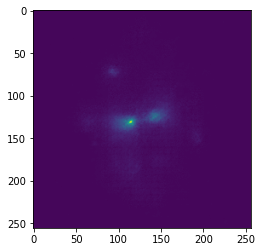

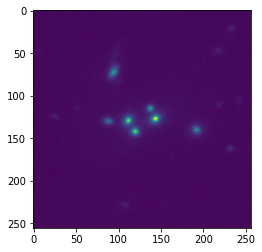

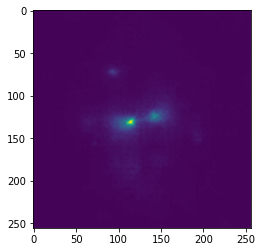

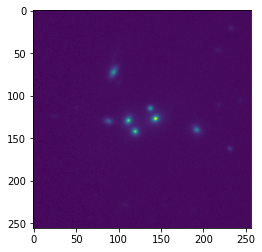

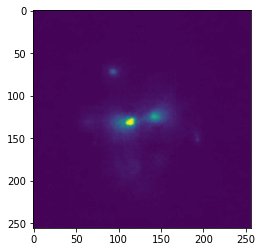

In [34]:
yunatu = img.cpu().numpy()
houtu = imgs.cpu().detach().numpy()
a=13

for i in range(3):
    
#     plt.subplot(3,2,1+2*i)
    plt.imshow(yunatu[a][i])    
    plt.show()
    # plt.imshow(yunatu[a][:,i,:])
#     plt.subplot(3,2,2+2*i)
    plt.imshow(houtu[a][i])
    plt.show()